# Dog Breed Image Classcifiction 

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [9]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install ipywidgets
!pip install torch torchvision tqdm

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDep

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
import boto3
import os

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-04-07 06:02:24--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  17.4MB/s    in 1m 43s  

2022-04-07 06:04:08 (10.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [3]:
import sagemaker
sagemaker_session = sagemaker.Session()

bucket = "sagemaker-studio-t3o9f3202l" #sagemaker-studio-t3o9f3202l for testing
prefix = "dogImages"

inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
print("input spec S3 path: {}".format(inputs))

KeyboardInterrupt: 

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [27]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameters = {"test-batch-size": "100"}
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2,10)
}

In [28]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "hptuning-imgclassification",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.m5.2xlarge", #The line need to be fixed.
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = "s3://sagemaker-studio-t3o9f3202l/output/"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 2,
    max_parallel_jobs = 2,
    objective_type = objective_type,
)

In [29]:
# TODO: Fit your HP Tuner
input_data = 's3://sagemaker-studio-t3o9f3202l/dogImages/'

In [30]:
# TODO: Fit your HP Tuner
tuner.fit({'train': input_data + 'train/',
           'test': input_data + 'test/',
           'val': input_data + 'valid/'}, wait = True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [31]:
# TODO: Get the best estimators and the best HP

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
best_hyperparameters


2022-04-08 09:32:59 Starting - Preparing the instances for training
2022-04-08 09:32:59 Downloading - Downloading input data
2022-04-08 09:32:59 Training - Training image download completed. Training in progress.
2022-04-08 09:32:59 Uploading - Uploading generated training model
2022-04-08 09:32:59 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'epochs': '8',
 'lr': '0.01601964735334812',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hptuning-imgclassification-2022-04-08-07-50-14-144"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-studio-t3o9f3202l/hptuning-imgclassification-2022-04-08-07-50-14-144/source/sourcedir.tar.gz"',
 'test-batch-size': '"100"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [3]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, DebuggerHookConfig, rule_configs, CollectionConfig
from sagemaker.debugger import ProfilerRule, ProfilerConfig, FrameworkProfile

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters = {"train.save_interval": "10", "eval.save_interval": "5"},
    collection_configs = [CollectionConfig(name = "CrossEntropyLoss_output_0",
                                           parameters = {
                                               "include_regex": "CrossEntropyLoss_output_0",
                                               "train.save_interval": "10",
                                               "eval.save_interval": "1"})]
)

In [4]:
hyperparameters = { "test-batch-size": "100",
                   "epochs": "8", #best_hyperparameters['epochs'],
                   "batch-size": "256", #int(best_hyperparameters['batch-size'].replace('"', '')),
                   "lr": "0.01601964735334812"} #best_hyperparameters['lr']}
hyperparameters

{'test-batch-size': '100',
 'epochs': '8',
 'batch-size': '256',
 'lr': '0.01601964735334812'}

In [5]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point = "train_model.py",
    base_job_name = "best-imgclassification",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.m5.2xlarge",
    hyperparameters = hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    output_path = "s3://sagemaker-studio-t3o9f3202l/output-best/",
    rules = rules,
    profiler_config = profiler_config,
    debugger_hook_config = hook_config
)
# TODO: Your estimator here

In [6]:
input_data = 's3://sagemaker-studio-t3o9f3202l/dogImages/'
estimator.fit({'train': input_data + 'train/',
               'test': input_data + 'test/',
               'val': input_data + 'valid/'}, wait = True)

2022-04-08 11:28:58 Starting - Starting the training job...
2022-04-08 11:29:19 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-04-08 11:30:58 Downloading - Downloading input data............
2022-04-08 11:32:59 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-08 11:32:47,194 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-04-08 11:32:47,196 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-04-08 11:32:47,205 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-08 11:32:47,215 sagemaker_pytorch_container.training 

In [7]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(job_name)

best-imgclassification-2022-04-08-11-28-58-061


In [10]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-04-08 13:26:03.975 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-08 13:26:03.999 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/debug-output
[2022-04-08 13:26:04.379 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 WARNING s3handler.py:183] Encountered the exception ('Connection broken: IncompleteRead(0 bytes read, 4784 more expected)', IncompleteRead(0 bytes read, 4784 more expected)) while reading s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/debug-output/index/000000000/000000000000_worker_0.json . Will retry now
[2022-04-08 13:26:09.208 datascience-1-0-ml-m5-large-ab1c8cfd3029fb39f3ca96edc853:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-04-08 13:

['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [11]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

84

In [12]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

126

In [13]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data", vals_train)
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data", vals_eval)

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data [array(4.955774, dtype=float32), array(13.249163, dtype=float32), array(4.946586, dtype=float32), array(4.9093404, dtype=float32), array(5.0479865, dtype=float32), array(5.073722, dtype=float32), array(5.2193274, dtype=float32), array(5.3265915, dtype=float32), array(5.4637713, dtype=float32), array(5.546347, dtype=float32), array(5.6436734, dtype=float32), array(4.427437, dtype=float32), array(4.367734, dtype=float32), array(4.5204673, dtype=float32), array(4.735224, dtype=float32), array(4.892105, dtype=float32), array(5.0673947, dtype=float32), array(5.14766, dtype=float32), array(5.3215475, dtype=float32), array(5.4429245, dtype=float32), array(5.4959006, dtype=float32), array(4.432787, dtype=float32), array(4.4055786, dtype=float32), array(4.556588, dtype=float32), array(4.662007, dtype=float32), array(4.8160095, dtype=float32), array(4.8345866, dtype=float32), array(5.0851507, dtype=float32), array(5.162208, dtype=float32), array(5.314653, dtype=float32), array(

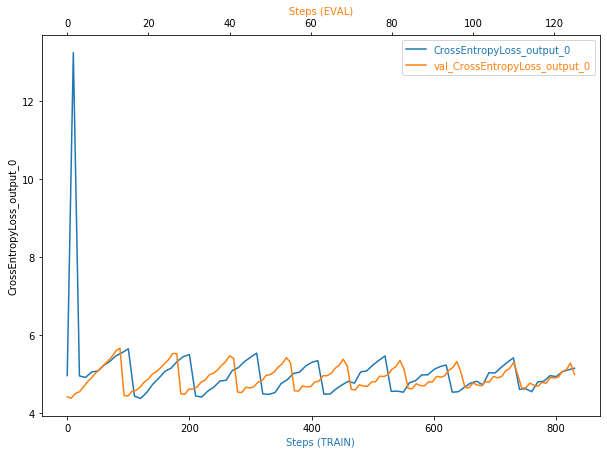

In [14]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

TODO: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?
TODO: If not, suppose there was an error. What would that error look like and how would you have fixed it?

1. No, it works fine, only taking too long to train, guess I can fix it by buying a better PC.

In [20]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [21]:
! aws s3 ls {rule_output_path} --recursive

2022-04-08 13:17:21     386850 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-04-08 13:17:21     236879 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-04-08 13:17:16        193 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-04-08 13:17:16        201 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-04-08 13:17:16       2101 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-04-08 13:17:16        127 output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-04-08 13:17:1

In [22]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMe

In [23]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [24]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [25]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")
# TODO: Add your deployment configuration like instance type and number of instances

-------!

In [26]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/output/model.tar.gz


In [27]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

role = get_execution_role()

In [28]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [29]:
model_location = "s3://sagemaker-studio-t3o9f3202l/output-best/best-imgclassification-2022-04-08-11-28-58-061/output/model.tar.gz"
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [31]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

In [32]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={
    "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

    #"https://project-imgclassify.s3.amazonaws.com/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

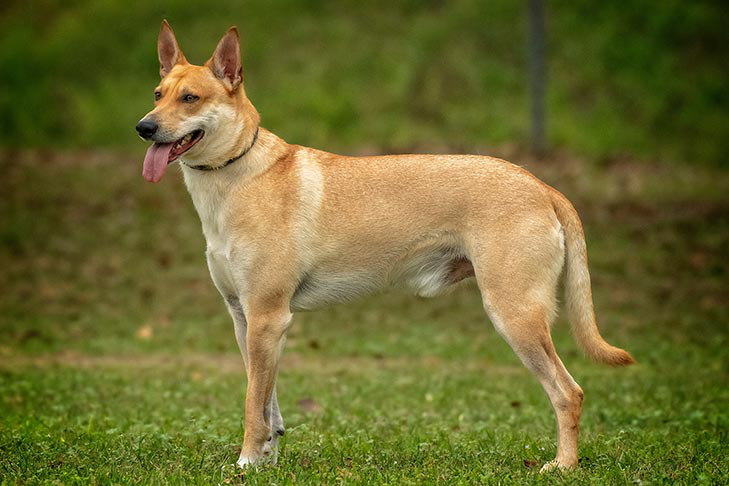

In [33]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [34]:
# TODO: Run an prediction on the endpoint

response = predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [35]:
type(response)
response

[[-0.44384312629699707,
  -0.5084381699562073,
  -0.6484436392784119,
  -0.49293437600135803,
  -0.33719325065612793,
  -0.47070086002349854,
  -0.6538204550743103,
  -0.4845814108848572,
  -1.0828256607055664,
  -0.6537542939186096,
  -0.44998258352279663,
  -0.4382312595844269,
  -0.7204356789588928,
  -0.4220438301563263,
  -0.3673570156097412,
  -0.49965664744377136,
  -0.47019150853157043,
  -0.6746267080307007,
  -0.7725298404693604,
  -0.5374665856361389,
  -0.5180730223655701,
  -0.7544889450073242,
  -0.4833208918571472,
  -0.5190671682357788,
  -0.9136940836906433,
  -0.9097931981086731,
  -0.5219507813453674,
  -0.9501073956489563,
  -0.3736003041267395,
  -0.626587450504303,
  -0.6027486324310303,
  -0.49604496359825134,
  -0.8151236772537231,
  -0.5095508098602295,
  -0.6765325665473938,
  -0.4918707609176636,
  -0.6996429562568665,
  -0.5692353844642639,
  -0.435550719499588,
  -0.6502825617790222,
  -0.4404163658618927,
  -0.5393778681755066,
  -0.7110849618911743,
  -0.

In [36]:
len(response[0])

133

In [37]:
import numpy as np
np.argmax(response, 1)

array([4])

In [38]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()